In [2]:
import json
import timeit
import functools 

import numpy as np 
import matplotlib.pyplot as plt

import ChebTools
import teqpflsh
import CoolProp.CoolProp as CP

In [3]:
j = json.load(open('superancillaryJSON/WATER_exps.json'))
sa = teqpflsh.SuperAncillary(json.dumps(j))

AS = CP.AbstractState('HEOS','Water')
def calc(T, rho, AS, key):
    AS.specify_phase(CP.iphase_gas)
    AS.update(CP.DmolarT_INPUTS, rho, T)
    val = AS.keyed_output(key)
    AS.unspecify_phase()
    return val

# Order of ms per variable, likely MUCH faster in C++
sa.add_variable(k='H', caller=functools.partial(calc, AS=AS, key=CP.iHmolar))
sa.add_variable(k='S', caller=functools.partial(calc, AS=AS, key=CP.iSmolar))
sa.add_variable(k='U', caller=functools.partial(calc, AS=AS, key=CP.iUmolar))

55504.316178396366 277.15003423906836


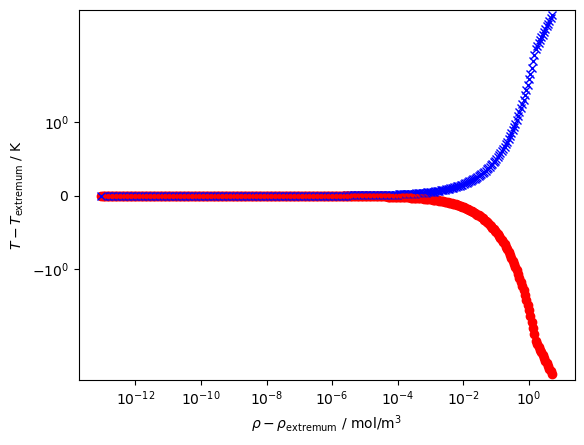

In [4]:
ca = sa.get_approx1d(k='D', q=0)

# Solving for temperature given saturated liquid density, around the density maximum
y_extremum = ca.eval(ca.x_at_extrema[0])
delta = y_extremum - 0.9999*y_extremum
print(y_extremum, ca.x_at_extrema[0])

while delta > 1e-13:
    Tsoln = ca.get_x_for_y(y=y_extremum-delta)
    if len(Tsoln) != 2:
        break
    if Tsoln[0][0] > Tsoln[1][0]:
        break
    
    delta /= 1.1
#     print(delta, Tsoln[0][0]-ca.x_at_extrema[0], Tsoln[1][0]-ca.x_at_extrema[0])
    plt.plot(delta, Tsoln[0][0]-ca.x_at_extrema[0], 'ro')
    plt.plot(delta, Tsoln[1][0]-ca.x_at_extrema[0], 'bx')
    
plt.xscale('log')
plt.yscale('symlog')
plt.gca().set(xlabel=r'$\rho-\rho_{\rm extremum}$ / mol/m$^3$', ylabel=r'$T-T_{\rm extremum}$ / K')
plt.show()

In [7]:
# Time forward evalution of a chebyshev expansion
T = np.linspace(273.16, 290, 100000)
ybuf = np.zeros_like(T)
tic = timeit.default_timer()
ca.eval_many(T, ybuf)
toc = timeit.default_timer()
print((toc-tic)/len(T)*1e6, 'μs/call')

# Time the rootfinding in the superancillary
tic = timeit.default_timer()
ybuf = np.linspace(55400, 55440, 1000000)
xbuf = np.zeros_like(ybuf)
ca.count_x_for_y_many(ybuf, 64, 100, 1e-10, xbuf)
toc = timeit.default_timer()
print((toc-tic)/len(xbuf)*1e6, 'μs/call')

0.09798875005799346 μs/call
0.5802335830085212 μs/call


Plot lines of constant quality in the two-phase region according to the superancillary functions

0.2694700808656397 17873.7282300601 [(437.3594696512889, 10)]
3.472920070635155 μs/call from 5.32 steps on average
4.154159978497773 μs/call from 8.15 steps on average
5.013329937355593 μs/call from 9.68 steps on average
5.214169941609725 μs/call from 10.06 steps on average
4.630000039469451 μs/call from 10.17 steps on average
4.724590107798576 μs/call from 10.55 steps on average
4.667920002248138 μs/call from 10.57 steps on average
4.778340080520138 μs/call from 10.85 steps on average
4.592500044964254 μs/call from 10.35 steps on average
4.381250037113205 μs/call from 9.86 steps on average
2.3808299738448113 μs/call from 5.33 steps on average
2.348749985685572 μs/call from 5.26 steps on average
2.3116599186323583 μs/call from 5.15 steps on average
2.7266700635664165 μs/call from 5.16 steps on average
2.335839963052422 μs/call from 5.26 steps on average
2.3462499666493386 μs/call from 5.27 steps on average
2.3358299222309142 μs/call from 5.23 steps on average
2.3629200586583465 μs/call

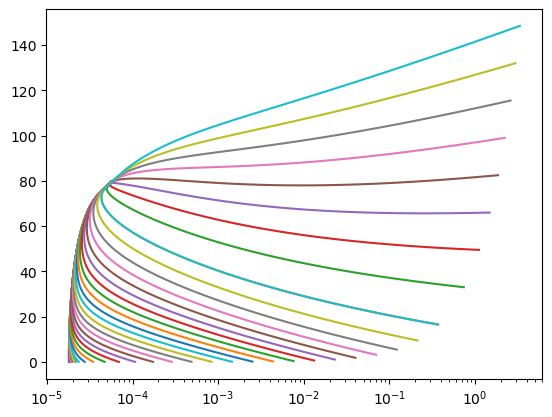

In [15]:
caV = sa.get_approx1d(k='D', q=1)
# for interval in caV.monotonic_intervals:
#     print(interval)
#     print({k: getattr(interval,k) for k in dir(interval) if not k.startswith('__')})
#     for m in interval.expansioninfo:
#         print({k: getattr(m,k) for k in dir(m) if not k.startswith('__')})
#         print(m.xmin, m.xmax)
print(caV.eval(273.16), caV.eval(647.096), caV.get_x_for_y(y=200))

# print([0].ymin, caV.monotonic_intervals[0].ymax)
# print(caV.get_x_for_y(y=200))

ca = sa.get_approx1d(k='D', q=0)
y = ca.eval(ca.x_at_extrema[0])*0.9999
Tlims = [_[0] for _ in ca.get_x_for_y(y=y)]

Ts = np.linspace(ca.expansions[0].xmin+1e-6, ca.expansions[-1].xmax-1e-6, 100)
# Ts = np.linspace(273.1600001, 280, 10000)

for Q in np.arange(1e-6, 1.0000, 0.1, dtype=float).tolist() + np.logspace(-8, -1, 30).tolist():
    Qs = Q*np.ones_like(Ts)
    
    rho = np.zeros_like(Ts)
    sa.get_yval_many(T=Ts, q=Qs, k='D', y=rho)
    
    other = np.zeros_like(Ts)
    kother = 'S'
    sa.get_yval_many(T=Ts, q=Qs, k=kother, y=other)
    plt.plot(1/rho, other)
    
    Tbuf = np.zeros_like(Ts)
    qbuf = np.zeros_like(Ts)
    countbuf = np.zeros_like(Ts)
    tic = timeit.default_timer()
    sa.solve_for_Tq_DX_many(rho, other, kother, 64, 100, 1e-10, Tbuf, qbuf, countbuf)
    toc = timeit.default_timer()
    print((toc-tic)/len(Tbuf)*1e6, 'μs/call from', np.mean(countbuf), 'steps on average')
    
    for T_goal_, rho_, other_ in zip(Ts, rho, other):
        soln = sa.solve_for_Tq_DX(rho_, other_, kother, 64, 100, 1e-10)
        try:
            T_ = soln.T; q_ = soln.q; count_ = soln.counter
        except BaseException as be:
            print(rho_, other_)
            print(be, T_goal_, Q)
            plt.plot(1/rho_, other_, 'o')
    
# plt.yscale('log')
plt.xscale('log')

In [ ]:
ca = sa.get_approx1d(k='D', q=0)
rhoc = ca.monotonic_intervals[1].ymin

for D in [22082.571366851185]:
    Tlims = [_ for _ in ca.get_x_for_y(y=D)]
    if len(Tlims) == 1:
        Trange = [ca.expansions[0].xmin, Tlims[0][0]]
    else:
        Trange = [Tlims[0][0], Tlims[1][0]]
    Ts = np.linspace(*Trange, 100000)
    # Non-iteratively solve for q for value of density
    q = np.array([sa.get_vaporquality(T=T_, propval=1/D, k='V') for T_ in Ts])
    # And then plot another property
    y = np.zeros_like(q)
    tic = timeit.default_timer()
    sa.get_yval_many(q=q, T=Ts, k='H', y=y)
    toc = timeit.default_timer()
    print((toc-tic)/len(T)*1e6, 'μs/call')
    plt.plot(Ts, y, label=D)
# plt.yscale('log')